# Support Vector Machine


In [1]:
import random
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from util import data_utils

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# import autoreload
# ?autoreload

## Load CIFAR-10 and preprocess

Convert images to zero mean 1-D array, along with the bias trick.


In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'util/datasets/cifar-10-batches-py'
    Xtrain, ytrain, Xtest, ytest = data_utils.load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = range(num_training, num_training + num_validation)
    Xval = Xtrain[mask]
    yval = ytrain[mask]
    mask = range(num_training)
    Xtrain = Xtrain[mask]
    ytrain = ytrain[mask]
    mask = range(num_test)
    Xtest = Xtest[mask]
    ytest = ytest[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    Xdev = Xtrain[mask]
    ydev = ytrain[mask]
    
    # Preprocessing: reshape the image data into rows
    Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], -1))
    Xval = np.reshape(Xval, (Xval.shape[0], -1))
    Xtest = np.reshape(Xtest, (Xtest.shape[0], -1))
    Xdev = np.reshape(Xdev, (Xdev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(Xtrain, axis = 0)
    Xtrain -= mean_image
    Xval -= mean_image
    Xtest -= mean_image
    Xdev -= mean_image
    
    # add bias dimension and transform into columns
    Xtrain = np.hstack([Xtrain, np.ones((Xtrain.shape[0], 1))])
    Xval = np.hstack([Xval, np.ones((Xval.shape[0], 1))])
    Xtest = np.hstack([Xtest, np.ones((Xtest.shape[0], 1))])
    Xdev = np.hstack([Xdev, np.ones((Xdev.shape[0], 1))])
    
    return Xtrain, ytrain, Xval, yval, Xtest, ytest, Xdev, ydev

Xtrain, ytrain, Xval, yval, Xtest, ytest, Xdev, ydev = get_CIFAR10_data()

## Softmax Classifier

In [84]:
from classifiers.softmax import softmax_loss_naive, softmax_loss_vectorized
from util.gradient_check import grad_check_sparse
import time

W = np.random.randn(3073, 10) * 0.0001
loss, dW = softmax_loss_vectorized(W, Xdev, ydev, 0.00001)
print("Sanity check", loss, -np.log(0.1))

Sanity check 2.38385050547 2.30258509299


In [77]:
scores = np.dot(Xdev, W)
dscores = np.exp(scores)
dscores /= np.sum(dscores, axis=1).reshape(-1, 1)

## Gradient Check
Verify computed analytic gradient with numerical gradient

In [87]:
loss, grad = softmax_loss_vectorized(W, Xdev, ydev, 1e2)
f = lambda w: softmax_loss_vectorized(w, Xdev, ydev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 2.185213 analytic: 2.185213, relative error: 3.105156e-09
numerical: 2.568474 analytic: 2.568474, relative error: 1.162134e-08
numerical: 0.302226 analytic: 0.302226, relative error: 1.793447e-07
numerical: -0.207808 analytic: -0.207808, relative error: 2.782630e-07
numerical: -1.616989 analytic: -1.616989, relative error: 4.173791e-08
numerical: -0.398573 analytic: -0.398573, relative error: 1.780074e-07
numerical: -2.974127 analytic: -2.974127, relative error: 3.384461e-08
numerical: -2.697595 analytic: -2.697595, relative error: 1.518468e-08
numerical: -0.367641 analytic: -0.367642, relative error: 1.993082e-07
numerical: -0.813687 analytic: -0.813687, relative error: 1.474352e-08


## Stocastic Gradient Descent

In [89]:
from classifiers.linear_classifier import Softmax

svm = Softmax()
loss_hist = svm.train(Xtrain, ytrain, learning_rate=1e-7, reg=5e+4, num_iters=1500, verbose=True)

iteration 0 / 1500: loss 765.523685848725
iteration 100 / 1500: loss 281.32809173888614
iteration 200 / 1500: loss 104.17716678014828
iteration 300 / 1500: loss 39.49332953926933
iteration 400 / 1500: loss 15.816399856812017
iteration 500 / 1500: loss 7.13824851092655
iteration 600 / 1500: loss 3.9097818619541123
iteration 700 / 1500: loss 2.7893505104817393
iteration 800 / 1500: loss 2.310572716828161
iteration 900 / 1500: loss 2.182009555068269
iteration 1000 / 1500: loss 2.080044215807532
iteration 1100 / 1500: loss 2.1705832212777403
iteration 1200 / 1500: loss 2.0444011014807044
iteration 1300 / 1500: loss 2.097037594454299
iteration 1400 / 1500: loss 2.0754821656277134


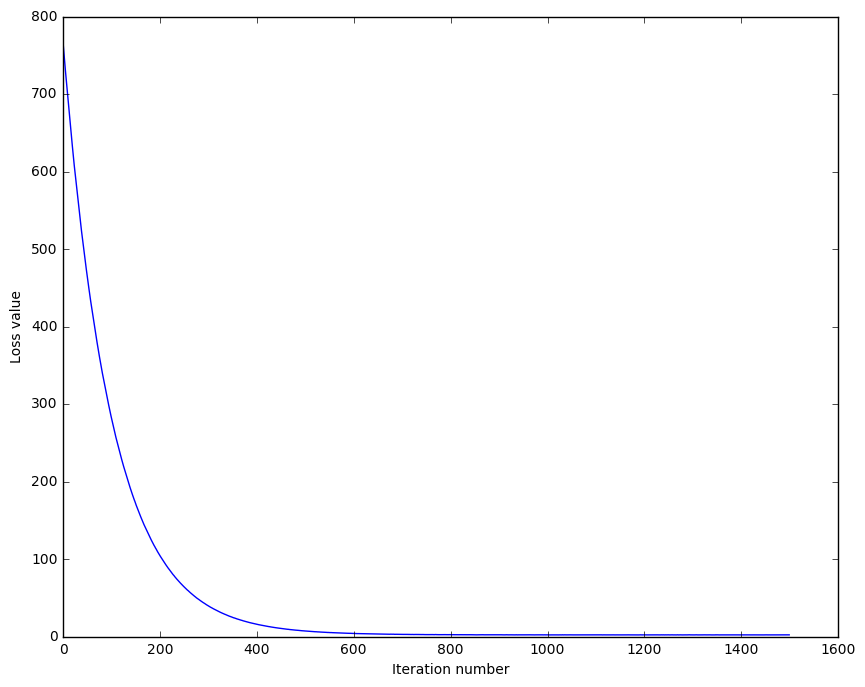

In [90]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [91]:
ytrainpred = svm.predict(Xtrain)
print('training accuracy: %f' % (np.mean(ytrain == ytrainpred),))
yvalpred = svm.predict(Xval)
print('validation accuracy: %f' % (np.mean(yval == yvalpred), ))

training accuracy: 0.327000
validation accuracy: 0.343000


## Vizualize results

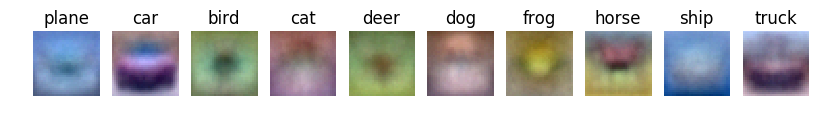

In [92]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(1, 10, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])